# **Creating a Scorecard with `OptBinning` tutorial**

The purpose of this notebook is to demonstrate the creation of a Scorecard using **OptBinning**.
More detail about the library can be found in the following links:
- [GitHub page](https://github.com/guillermo-navas-palencia/optbinning)
- [Official Documentation](http://gnpalencia.org/optbinning/#)
- Article(Developing Scorecards in Python using OptBinning) 



In [2]:
import pandas as pd
from optbinning import Scorecard, BinningProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## 1. Loading dataset
The dataset used in this tutorial is available at Kaggle and was part of the "Home Credit Default Risk" Challenge.
- https://www.kaggle.com/c/home-credit-default-risk/data


### 1.1. Table Application Train
The data available for the challenge is distributed throughout 8 CSV files:

* application_train.csv
* previous_application.csv
* credit_card_balance.csv
* POS_CASH_balance.csv
* installments_payments.csv
* bureau_balance.csv
* bureau.csv

Also available is the description for each column in tables (`HomeCredit_columns_description.csv`), and the application test and submission tables (`application_test.csv` and `sample_submission.csv`).

In order to make the tutorial as accessible as possible we are going to only use the `application_train.csv` file to develop the Scorecard.

In [27]:
df_application = pd.read_csv('./home-credit-default-risk/application_train.csv', low_memory=True)
df_application.set_index('SK_ID_CURR', inplace=True)
df_application.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
df_application_train, df_application_test, y_train, y_test = train_test_split(
    df_application, df_application.TARGET, test_size=0.2, random_state=42)


### 1.2. Checking categorical features
`Optbinning` needs the information whether the features are numerical or categorical.
So we are going to verify the dtypes of each column to make sure it's correct. 

In [22]:
df_application_train.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [23]:
df_application_train.select_dtypes(include='object')

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
SK_ID_CURR,,,,,,,,,,,,,,,,
219825,Revolving loans,M,Y,N,"Spouse, partner",Working,Higher education,Married,House / apartment,High skill tech staff,TUESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
127675,Cash loans,M,N,N,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,SATURDAY,XNA,NaN,NaN,NaN,NaN
172537,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,SUNDAY,Self-employed,NaN,block of flats,"Stone, brick",No
243292,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Higher education,Separated,House / apartment,Security staff,WEDNESDAY,Transport: type 4,NaN,block of flats,"Stone, brick",No
172903,Cash loans,F,N,N,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,NaN,THURSDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243982,Cash loans,F,Y,N,Unaccompanied,Working,Higher education,Single / not married,With parents,Sales staff,THURSDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
340077,Cash loans,F,Y,Y,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,Medicine staff,MONDAY,Medicine,NaN,NaN,NaN,NaN
308111,Cash loans,F,Y,Y,Unaccompanied,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,NaN,WEDNESDAY,XNA,NaN,block of flats,NaN,No


## 2. Creating the `BinningProcess` instance
The `Scorecard` need an instance of `BinningProcess` with the corresponding data for the dataset and also an `sklearn.linear_model`. <br>
We can also provide a `selection_criteria` for the selection of features.

In [8]:
list_features = df_application_train.drop(columns=['TARGET']).columns.values
list_categorical = df_application_train.select_dtypes(include=['object', 'category']).columns.values
selection_criteria = {"iv": {"min": 0.005, 'max':0.5, "strategy": "highest"}}

In [9]:
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_features,
    selection_criteria=selection_criteria,
)

## 3. Defining the Linear Estimator
`Scorecard` accepts any Linear Estimator from Scikit-Learn. 

In [24]:
logreg = LogisticRegression(C=3, max_iter=1000, random_state=161)

## 4. Creating a Scorecard
To instantiate the `Scorecard` class you need to pass as parameters the `binning_process` and linear model (`log_reg`), 

In [26]:
df_application_train.shape

(125955, 121)

In [25]:
%%time
scaling_method = "min_max"
scaling_method_data = {"min": 0, "max": 1000}
scorecard = Scorecard(
    target='TARGET',
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=False,
    reverse_scorecard=True,
)

scorecard.fit(df_application_train)

CPU times: user 35.6 s, sys: 9.55 s, total: 45.2 s
Wall time: 19.1 s


Scorecard(binning_process=BinningProcess(categorical_variables=array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSM...
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype=object)),
          estimator=LogisticRegression(C=3, max_iter=1000, random_state=161),
          reverse_scorecard=True, scaling_method='min_max',
          scaling_method_params={'max': 1000, 'min': 0}, target='TARGET')

## 5. Visualizing Scorecard
To access the Scorecard table with metrics and points for each feature and bin you simply run the method `table` for your `Scorecard` fitted instance.

### 5.1. Saving the Scorecard table

In [32]:
scorecard_summary = scorecard.table(style="detailed").round(3)
scorecard_summary.to_csv('scorecard_table_detailed.csv', index=False)
scorecard_summary

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,NAME_CONTRACT_TYPE,0,[Revolving loans],12056,0.096,11415,641,0.053,0.440,0.015,0.002,-0.628,-6.566
1,NAME_CONTRACT_TYPE,1,[Cash loans],113899,0.904,104437,9462,0.083,-0.038,0.001,0.000,-0.628,6.815
2,NAME_CONTRACT_TYPE,2,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.628,5.747
3,NAME_CONTRACT_TYPE,3,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.628,5.747
0,CODE_GENDER,0,"[XNA, F]",82896,0.658,77096,5800,0.070,0.148,0.013,0.002,-0.738,0.888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,AMT_REQ_CREDIT_BUREAU_YEAR,1,"[0.50, 1.50)",25941,0.206,24047,1894,0.073,0.102,0.002,0.000,-0.388,3.988
2,AMT_REQ_CREDIT_BUREAU_YEAR,2,"[1.50, 4.50)",42928,0.341,39509,3419,0.080,0.008,0.000,0.000,-0.388,5.614
3,AMT_REQ_CREDIT_BUREAU_YEAR,3,"[4.50, inf)",10770,0.086,9808,962,0.089,-0.118,0.001,0.000,-0.388,7.776
4,AMT_REQ_CREDIT_BUREAU_YEAR,4,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.388,5.747


### 5.2. Visualizing Scorecard performance

In [48]:
from optbinning.scorecard.plots import plot_ks, plot_auc_roc

In [50]:
df_application_test.loc[:,"predict_proba"] = scorecard.predict_proba(df_application_test)[:, 1]
df_application_test.loc[:,"score"] = scorecard.score(df_application_test)

/home/gabriel/miniconda3/envs/optbinning_tutorial/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [44]:
df_application_test.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,predict_proba,score
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,418500.0,...,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.205068,566.705976
214010,0,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,1179000.0,...,0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.021774,453.765999
142232,0,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,495000.0,...,0,0,0.0,0.0,0.0,1.0,0.0,3.0,0.128965,541.973670
389171,0,Cash loans,F,N,Y,0,247500.0,254700.0,24939.0,225000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.015097,431.134660
283617,0,Cash loans,M,N,Y,0,112500.0,308133.0,15862.5,234000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.085480,520.647527


In [71]:
plot_ks(df_application_test.TARGET, df_application_test.score, savefig=True, fname='scorecard_ks_plot.jpeg', dpi=100)

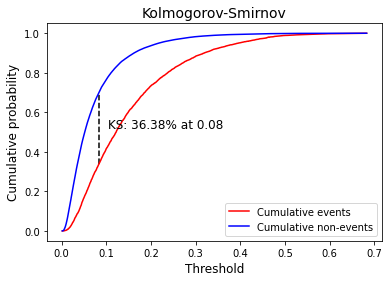

In [53]:
plot_ks(df_application_test.TARGET, df_application_test.predict_proba)

In [72]:
plot_auc_roc(df_application_test.TARGET, df_application_test.score, savefig=True, fname='scorecard_rocauc_plot.jpeg', dpi=100)

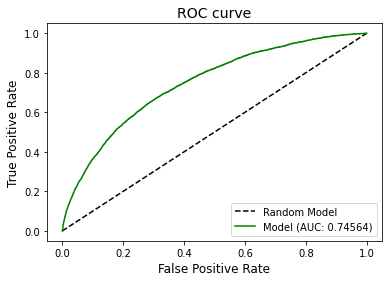

In [68]:
plot_auc_roc(df_application_test.TARGET, df_application_test.predict_proba)